In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import os

import numpy as np

from ipywidgets import interact, IntSlider
from colorama import Fore, Style
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

from torch.utils.data import DataLoader
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

print(torch.__version__) 
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0)) 


2.2.2+cu118
True
NVIDIA GeForce RTX 3060 Laptop GPU


---

#### Предварительно настроим стили графиков.

---

In [2]:
plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-light.mplstyle')

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc}\usepackage[russian]{babel}',
    'axes.labelsize': 21, # названия осей 
    'xtick.labelsize': 16, # значения осей 
    'ytick.labelsize': 16, # значения осей
    'legend.fontsize': 12,  
    'axes.titlesize': 16,
})

---

#### Загрузим данные. И составим DataFrame.

---

In [3]:
df_data_2_years = pd.read_excel('input\\CHTETS4-Data-GT2-2022-2023-v2-18.08.2024.xlsx', sheet_name='Data', header = 10)

In [4]:
df_data_2_years = df_data_2_years.iloc[21:]

df_data_2_years.drop(columns="Unnamed: 0", inplace=True)
df_data_2_years.rename(columns={"SID": 'time'}, inplace=True)

In [5]:
df_data_2_years

,time,CHTEC4_TTO.12441,CHTEC4_TTO.12442,CHTEC4_TTO.12443,CHTEC4_TTO.12451,CHTEC4_TTO.12452,CHTEC4_TTO.12453,CHTEC4_TTO.12454,CHTEC4_TTO.12458,CHTEC4_TTO.12459,CHTEC4_TTO.12460,CHTEC4_TTO.12470,CHTEC4_TTO.12496,CHTEC4_TTO.12499,CHTEC4_TTO.22507,CHTEC4_TTO.22788,CHTEC4_TTO.22789,CHTEC4_TTO.22790,CHTEC4_TTO.22791
21,01.01.22 00:00,502.630018,14.727956,370.510894,73.537194,989.92813,-8.94626,981.705389,-5.770616,-7.038308,-5.355228,26.057132,1088.157471,92.764932,143.33443,4.903523,3.202395,15.250076,22.18531
22,01.01.22 01:00,502.297954,14.388092,370.558608,72.710003,989.452242,-8.714137,981.244018,-5.674671,-6.800248,-5.258674,26.01752,1088.157471,89.501112,144.345204,6.218756,3.265654,15.236482,21.96653
23,01.01.22 02:00,501.459262,14.4344,370.770397,73.678753,988.976354,-8.663222,980.782647,-5.578726,-6.562189,-5.162121,25.942435,1088.157471,89.911645,152.145919,6.73904,3.309285,15.122888,22.330646
24,01.01.22 03:00,500.62057,14.460314,370.982187,74.330347,988.499748,-8.778288,980.321276,-5.482781,-6.32413,-5.065567,25.956258,1088.157471,90.267643,143.503805,2.387159,3.133892,15.14222,22.306482
25,01.01.22 04:00,499.781878,14.486229,371.193976,74.178782,987.890632,-8.466152,979.865337,-5.386836,-6.124291,-4.969013,25.996714,1088.157471,90.510812,125.222104,1.059052,3.21163,14.983702,23.220673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17536,31.12.23 19:00,499.366265,14.893851,382.381074,87.914941,974.964563,-7.015762,963.382417,-3.231133,-4.259275,-2.673324,25.973933,1087.699707,95.274803,170.056588,4.470761,2.404646,16.731874,17.994607
17537,31.12.23 20:00,499.256774,14.877725,383.967367,89.716873,974.693103,-6.60099,962.884628,-1.698285,-2.933223,-1.033371,26.079173,1087.699707,96.224249,169.893957,4.628182,2.391174,16.703997,18.005851
17538,31.12.23 21:00,499.147282,14.839352,386.434564,91.524582,974.421643,-5.903147,962.386838,-0.20651,-1.815289,1.092264,25.991399,1087.699707,96.653807,169.731325,4.785602,2.377701,16.716452,17.892207
17539,31.12.23 22:00,499.037791,14.800978,388.854944,93.295846,974.150183,-5.024202,961.889048,1.181107,-0.568284,2.621017,26.000856,1087.699707,97.031287,169.568694,4.943023,2.364229,16.701704,17.868458


<!DOCTYPE html>
<html lang="ru">
<head>
<hr>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Проверка данных</title>
  <style>
    body {
      font-family: Arial, sans-serif;
      text-align: center;
      margin: 50px;
    }
    .title-container {
      display: flex;
      justify-content: center;
      align-items: center;
    }
    .title {
      font-size: 34px;
      font-weight: bold;
      text-align: center;
      margin-bottom: 1px; 
    }
    .steps-row {
      display: flex;
      justify-content: center;
      align-items: center;
      gap: 50px;
    }
    .step-container {
      display: flex;
      flex-direction: column;
      align-items: center;
    }
    .arrow {
      font-size: 50px;
      color: gray;
      margin-bottom: 20px; 
      margin-top: 20px; 
    }
    .arrow:first-of-type {
      margin-left: 700px;
    }
    .step {
      background: #007bff;
      color: white;
      font-weight: bold;
      padding: 15px 10px; 
      border-radius: 20px;
      font-size: 18px;
      text-align: center;
      width: auto;
    }
  </style>
</head>
<body>
  <div class="title-container">
    <div class="title">Видно, что данные записывались каждый час - используем это, проверив:</div>
  </div>
  <div class="steps-row">
    <div class="step-container">
      <div class="arrow">↙</div>
      <div class="step">1. Количество записей в данных соответствуют 2 годам.</div>
    </div>
    <div class="step-container">
      <div class="arrow">↘</div>
      <div class="step">2. Нет дубликатов по времени.</div>
    </div>
  </div>
  <hr>
</body>
</html>




In [6]:
def check_time_pass(data: pd.DataFrame) -> None:
    """
    Проверяет временные данные на наличие пропусков и дубликатов.

    Функция выполняет две проверки:
    1. Проверяет, что количество уникальных временных меток (time) == двум полным годам (24 часа * 365 дней * 2);
    2. Проверяет, что количество уникальных временных меток (time) == количеству строк в данных (data) (отсутствие дубликатов);

    Параметры:
    data (pd.DataFrame): Датафрейм с колонкой 'time', содержащей временные метки. (Например df_data_2_years).

    Исключения:
    ValueError: Прерывается работа скрипта, если обнаружены временные пропуски или дубликаты.

    Возвращает: None.
    """
    if data.time.nunique() / 24 / 365 != 2:
        raise ValueError(f"{Fore.LIGHTRED_EX}🚨 Есть временные пропуски{Style.RESET_ALL}")
    
    if data.time.nunique() != data.shape[0]:
        raise ValueError(f"{Fore.LIGHTRED_EX}🚨 Есть дубликаты по времени{Style.RESET_ALL}")
    
    print(f"{Fore.LIGHTGREEN_EX}✅ OK{Style.RESET_ALL} | В данных все хорошо! Нет пропусков по времени и дубликатов.")

    

check_time_pass(df_data_2_years)

✅ OK | В данных все хорошо! Нет пропусков по времени и дубликатов.


In [7]:
def check_missing_values(data: pd.DataFrame) -> None:
    """
    Провряет наличие пропущенных значений в датафрейме.

    Функция выводит количество пропусков в каждом столбце.  
    Если пропуски есть, выводит предупреждение.  
    Если пропусков нет, сообщает, что всё в порядке.

    Параметры:
    data (pd.DataFrame): Датафрейм для проверки (например df_data_2_years).

    Возвращает: None.
    """
    missing = data.isna().sum()
    missing = missing[missing > 0]

    if not missing.empty:
        message = f"🚨 {Fore.LIGHTRED_EX}Найдены пропуски:\n{Style.RESET_ALL}" + "\n".join(f"{col}: {count}" for col, count in missing.items())
        raise ValueError(f"{message}")
    
    print(f"{Fore.LIGHTGREEN_EX}✅ OK{Style.RESET_ALL} | Пропусков нет!")



check_missing_values(df_data_2_years)

✅ OK | Пропусков нет!


In [8]:
df_data_2_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 21 to 17540
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   time              17520 non-null  object
 1   CHTEC4_TTO.12441  17520 non-null  object
 2   CHTEC4_TTO.12442  17520 non-null  object
 3   CHTEC4_TTO.12443  17520 non-null  object
 4   CHTEC4_TTO.12451  17520 non-null  object
 5   CHTEC4_TTO.12452  17520 non-null  object
 6   CHTEC4_TTO.12453  17520 non-null  object
 7   CHTEC4_TTO.12454  17520 non-null  object
 8   CHTEC4_TTO.12458  17520 non-null  object
 9   CHTEC4_TTO.12459  17520 non-null  object
 10  CHTEC4_TTO.12460  17520 non-null  object
 11  CHTEC4_TTO.12470  17520 non-null  object
 12  CHTEC4_TTO.12496  17520 non-null  object
 13  CHTEC4_TTO.12499  17520 non-null  object
 14  CHTEC4_TTO.22507  17520 non-null  object
 15  CHTEC4_TTO.22788  17520 non-null  object
 16  CHTEC4_TTO.22789  17520 non-null  object
 17  CHTEC4_TTO.

---

#### Поменяем тип данных.

---

In [9]:
df_data_2_years['time'] = pd.to_datetime(df_data_2_years['time'])

columns_to_convert = df_data_2_years.columns.difference(['time'])
df_data_2_years[columns_to_convert] = df_data_2_years[columns_to_convert].astype(float)

---

Проверки пройдены, можем нарисовать графики.

---

In [10]:
df_data_2_years.sort_values(by = 'time', inplace = True)

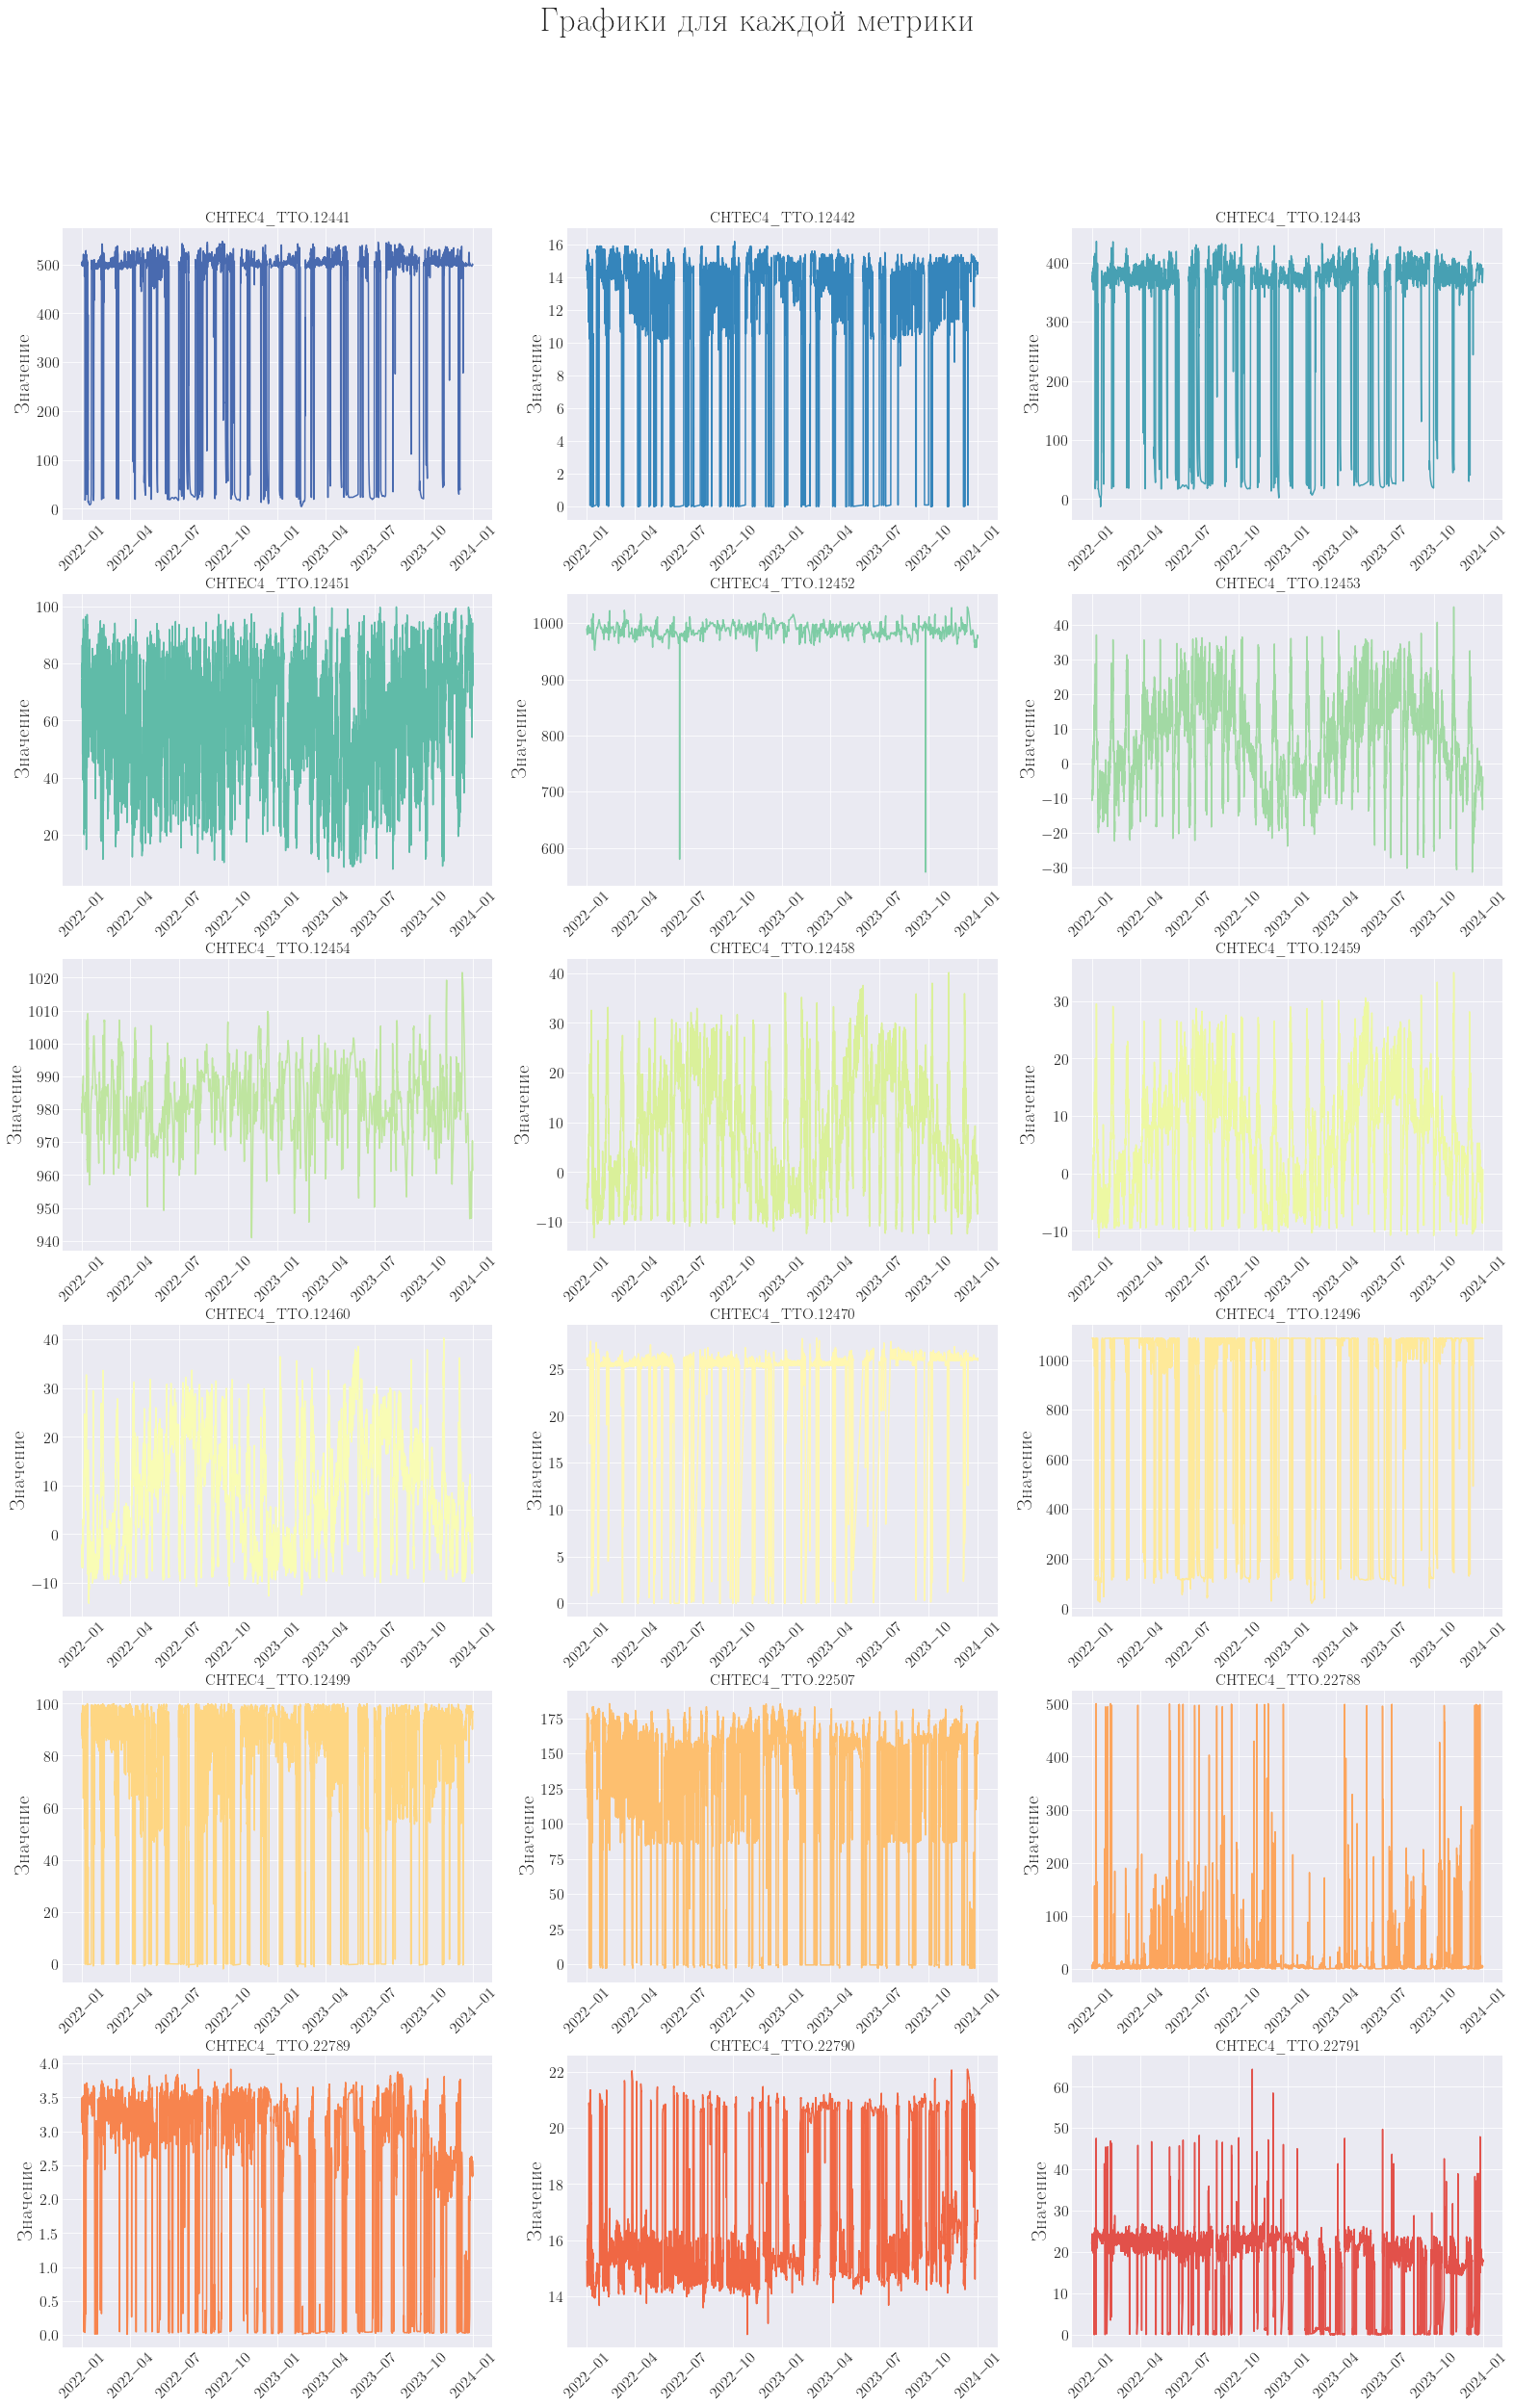

In [11]:
start_index = 0
palette = sns.color_palette("Spectral", n_colors=start_index+20)
palette = palette[::-1]
colors = palette[start_index:] + palette[:start_index]

time_column = 'time'
columns_to_plot = df_data_2_years.columns[1:]

plt.figure(figsize=(22, 40))

for i, column in enumerate(columns_to_plot):
    plt.subplot(len(columns_to_plot) // 3 + 1, 3, i + 1) 
    plt.plot(df_data_2_years[time_column], df_data_2_years[column], label=column, color = colors[i])
    # plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.title(f'{column}')
    plt.xticks(rotation=45) 

plt.suptitle('Графики для каждой метрики', fontsize=36)
plt.tight_layout()  
plt.subplots_adjust(top=0.9)  
plt.show()


---

#### Видно, что есть выбросы и сезонность. 

---

---

# Метеорологический Датасет

---

Загрузим метеоданные по географической локации Челябинская ТЭЦ-4 за 2022-2023 года с кратностью в 1 час:

- latitude = 55.204716
- longitude = 61.407467

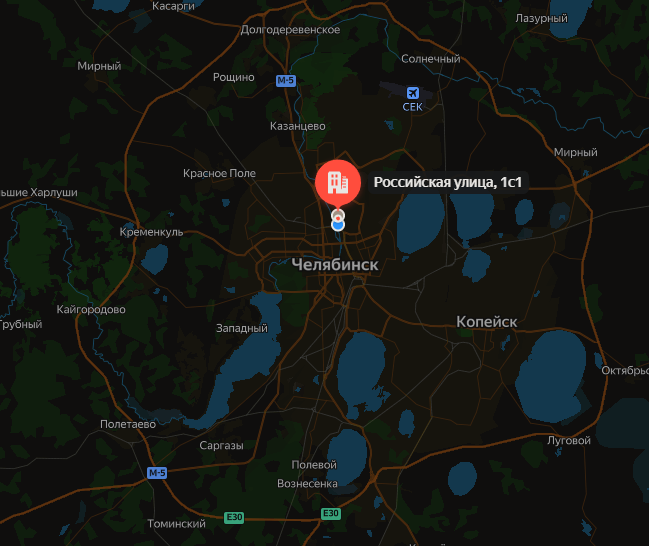
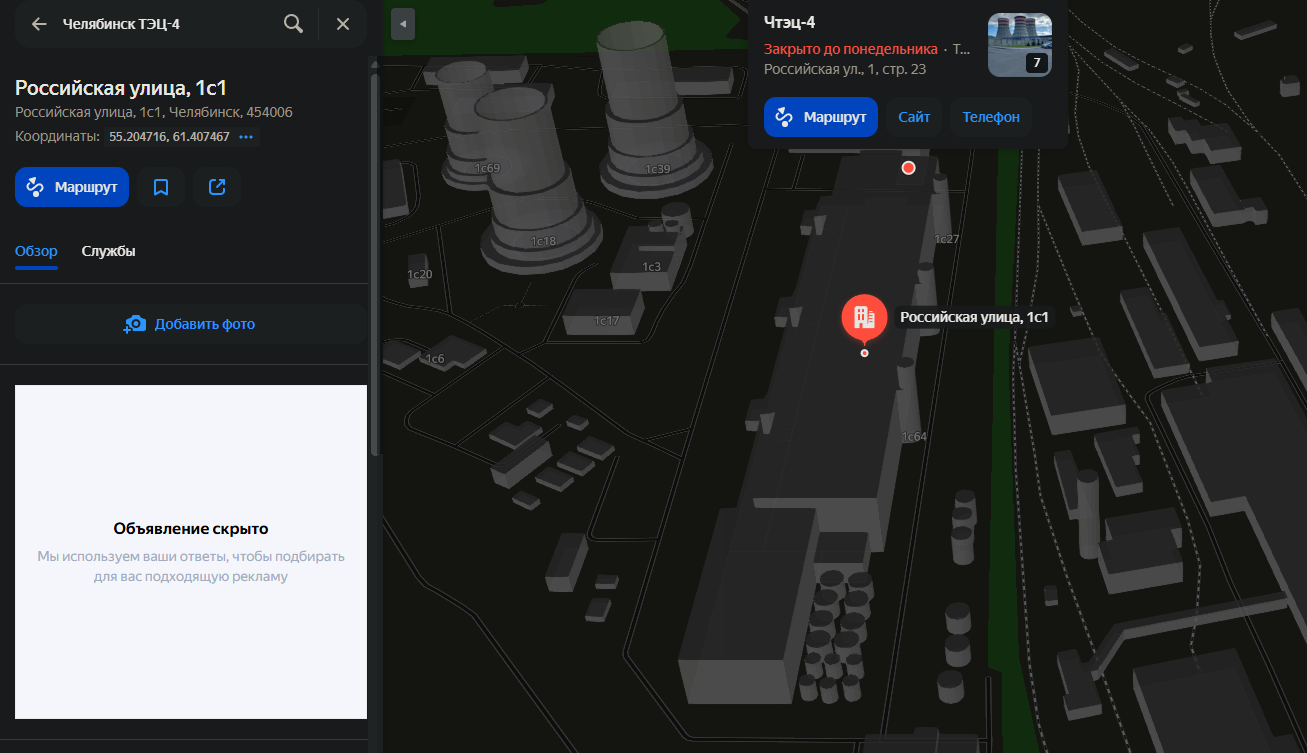

In [12]:
try:
    df = pd.read_csv('chelyabinsk_tecz4_weather.csv')
except:
    # Координаты Челябинской ТЭЦ-4
    latitude = 55.204716
    longitude = 61.407467

    # URL архивного API
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "cloudcover,relative_humidity_2m,precipitation,pressure_msl,temperature_2m,wind_speed_10m,wind_direction_10m",
        "start_date": "2022-01-01",
        "end_date": "2023-12-31",
        "timezone": "Europe/Moscow"
    }

    response = requests.get(url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": data["hourly"]["time"],
        "cloud_cover": data["hourly"]["cloudcover"],
        "humidity": data["hourly"]["relative_humidity_2m"],
        "precipitation": data["hourly"]["precipitation"],
        "pressure": data["hourly"]["pressure_msl"],
        "temperature": data["hourly"]["temperature_2m"],
        "wind_speed": data["hourly"]["wind_speed_10m"],
        "wind_direction": data["hourly"]["wind_direction_10m"]
    })

    df.to_csv("chelyabinsk_tecz4_weather.csv", index=False)

    print("Исторические данные успешно загружены и сохранены в chelyabinsk_tecz4_weather.csv")


---

#### Проверим данные.

---

In [13]:
check_time_pass(df)
check_missing_values(df)

✅ OK | В данных все хорошо! Нет пропусков по времени и дубликатов.
✅ OK | Пропусков нет!


In [14]:
df

,time,cloud_cover,humidity,precipitation,pressure,temperature,wind_speed,wind_direction
0,2022-01-01T00:00,91,82,0.0,1020.7,-10.5,12.2,194
1,2022-01-01T01:00,98,81,0.0,1020.0,-10.8,13.9,190
2,2022-01-01T02:00,99,80,0.0,1019.6,-11.4,15.4,191
3,2022-01-01T03:00,40,78,0.0,1018.9,-10.6,17.6,195
4,2022-01-01T04:00,99,79,0.0,1018.1,-11.3,17.4,193
...,...,...,...,...,...,...,...,...
17515,2023-12-31T19:00,100,94,0.2,1005.4,-6.1,16.9,164
17516,2023-12-31T20:00,100,95,0.7,1004.3,-3.7,17.7,168
17517,2023-12-31T21:00,100,94,0.8,1002.9,-1.3,21.1,172
17518,2023-12-31T22:00,100,93,0.2,1002.1,-0.3,24.5,182


---

Посмотрим тип данных.

---

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            17520 non-null  object 
 1   cloud_cover     17520 non-null  int64  
 2   humidity        17520 non-null  int64  
 3   precipitation   17520 non-null  float64
 4   pressure        17520 non-null  float64
 5   temperature     17520 non-null  float64
 6   wind_speed      17520 non-null  float64
 7   wind_direction  17520 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.1+ MB


In [16]:
df['time'] = pd.to_datetime(df['time'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            17520 non-null  datetime64[ns]
 1   cloud_cover     17520 non-null  int64         
 2   humidity        17520 non-null  int64         
 3   precipitation   17520 non-null  float64       
 4   pressure        17520 non-null  float64       
 5   temperature     17520 non-null  float64       
 6   wind_speed      17520 non-null  float64       
 7   wind_direction  17520 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 1.1 MB


In [18]:
df.head(3)

,time,cloud_cover,humidity,precipitation,pressure,temperature,wind_speed,wind_direction
0,2022-01-01 00:00:00,91,82,0.0,1020.7,-10.5,12.2,194
1,2022-01-01 01:00:00,98,81,0.0,1020.0,-10.8,13.9,190
2,2022-01-01 02:00:00,99,80,0.0,1019.6,-11.4,15.4,191



---

## Характеристики данных

- **Количество записей:** 17520  
- **Количество признаков:** 8  
- **Пропущенные значения:** Отсутствуют 

---

## Структура данных

|**Название столбца**       | **Описание**                                                                                      | **Тип данных** |
|----------------------------|---------------------------------------------------------------------------------------------------|----------------|
| `time`                    | Временная метка (yyyy-mm-dd hh-mm-ss) записи данных                                                | `datetime64[ns]`|
| `cloud_cover`             | Облачность, %. Показывает долю неба, покрытую облаками                                           | `int64`        |
| `humidity`                | Относительная влажность воздуха, %                                                              | `int64`        |
| `precipitation`           | Количество осадков за час, мм                                                    | `float64`      |
| `pressure`                | Атмосферное давление, гПа                                                           | `float64`      |
| `temperature`             | Температура воздуха, °C                                                    | `float64`      |
| `wind_speed`              | Скорость воздушного потока                   | `float64`      |
| `wind_direction`          | Направление ветра     | `int64`        |


---

---

## Статистика по данным

In [19]:
df.describe()

,cloud_cover,humidity,precipitation,pressure,temperature,wind_speed,wind_direction
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,64.316381,70.043607,0.057443,1017.432745,4.281330,12.757323,211.724201
std,41.427219,18.731398,0.298223,11.625777,13.419786,5.511396,95.641902
min,0.000000,8.000000,0.000000,978.400000,-38.200000,0.000000,1.000000
25%,17.000000,58.000000,0.000000,1009.600000,-6.000000,8.700000,160.000000
50%,93.000000,75.000000,0.000000,1017.200000,5.200000,12.100000,223.000000
75%,100.000000,84.000000,0.000000,1024.200000,15.100000,16.200000,290.000000
max,100.000000,100.000000,8.900000,1063.100000,38.300000,40.400000,360.000000


----


### Построим графики

---

In [20]:
dict_description = {
    "time": {
        "description": "Временная метка",
        "data_type": "datetime64[ns]"
    },
    "cloud_cover": {
        "description": "Облачность",
        "data_type": "int64"
    },
    "humidity": {
        "description": "Относительная влажность воздуха",
        "data_type": "int64"
    },
    "precipitation": {
        "description": "Количество осадков за час, мм",
        "data_type": "float64"
    },
    "pressure": {
        "description": "Атмосферное давление, гПа",
        "data_type": "float64"
    },
    "temperature": {
        "description": "Температура воздуха, °C",
        "data_type": "float64"
    },
    "wind_speed": {
        "description": "Скорость воздушного потока",
        "data_type": "float64"
    },
    "wind_direction": {
        "description": "Направление ветра",
        "data_type": "int64"
    }
}

---

# Обучение

---

In [28]:
target_column = 'CHTEC4_TTO.22789'
# target_column = 'CHTEC4_TTO.22791'

In [29]:
df_merge = pd.merge(df_data_2_years, df, on='time')

In [30]:
df_merge

,time,CHTEC4_TTO.12441,CHTEC4_TTO.12442,CHTEC4_TTO.12443,CHTEC4_TTO.12451,CHTEC4_TTO.12452,CHTEC4_TTO.12453,CHTEC4_TTO.12454,CHTEC4_TTO.12458,CHTEC4_TTO.12459,...,CHTEC4_TTO.22789,CHTEC4_TTO.22790,CHTEC4_TTO.22791,cloud_cover,humidity,precipitation,pressure,temperature,wind_speed,wind_direction
0,2022-01-01 00:00:00,502.630018,14.727956,370.510894,73.537194,989.928130,-8.946260,981.705389,-5.770616,-7.038308,...,3.202395,15.250076,22.185310,91,82,0.0,1020.7,-10.5,12.2,194
1,2022-01-01 01:00:00,502.297954,14.388092,370.558608,72.710003,989.452242,-8.714137,981.244018,-5.674671,-6.800248,...,3.265654,15.236482,21.966530,98,81,0.0,1020.0,-10.8,13.9,190
2,2022-01-01 02:00:00,501.459262,14.434400,370.770397,73.678753,988.976354,-8.663222,980.782647,-5.578726,-6.562189,...,3.309285,15.122888,22.330646,99,80,0.0,1019.6,-11.4,15.4,191
3,2022-01-01 03:00:00,500.620570,14.460314,370.982187,74.330347,988.499748,-8.778288,980.321276,-5.482781,-6.324130,...,3.133892,15.142220,22.306482,40,78,0.0,1018.9,-10.6,17.6,195
4,2022-01-01 04:00:00,499.781878,14.486229,371.193976,74.178782,987.890632,-8.466152,979.865337,-5.386836,-6.124291,...,3.211630,14.983702,23.220673,99,79,0.0,1018.1,-11.3,17.4,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2023-12-31 19:00:00,499.366265,14.893851,382.381074,87.914941,974.964563,-7.015762,963.382417,-3.231133,-4.259275,...,2.404646,16.731874,17.994607,100,94,0.2,1005.4,-6.1,16.9,164
17516,2023-12-31 20:00:00,499.256774,14.877725,383.967367,89.716873,974.693103,-6.600990,962.884628,-1.698285,-2.933223,...,2.391174,16.703997,18.005851,100,95,0.7,1004.3,-3.7,17.7,168
17517,2023-12-31 21:00:00,499.147282,14.839352,386.434564,91.524582,974.421643,-5.903147,962.386838,-0.206510,-1.815289,...,2.377701,16.716452,17.892207,100,94,0.8,1002.9,-1.3,21.1,172
17518,2023-12-31 22:00:00,499.037791,14.800978,388.854944,93.295846,974.150183,-5.024202,961.889048,1.181107,-0.568284,...,2.364229,16.701704,17.868458,100,93,0.2,1002.1,-0.3,24.5,182


In [31]:
targets = ['CHTEC4_TTO.22789']
# targets = ['CHTEC4_TTO.22791']
features = ['cloud_cover', 'humidity', 'precipitation', 'pressure', 'temperature', 'wind_speed', 'wind_direction']

In [32]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        """
        input_dim: число признаков (например, количество погодных переменных)
        hidden_dim: размер скрытого состояния LSTM
        num_layers: число слоев LSTM
        output_dim: размер выхода (в нашем случае 1, т.к. предсказываем одно значение)
        """
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x имеет размер (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # Берем выход последнего временного шага
        last_out = lstm_out[:, -1, :]
        out = self.fc(last_out)
        return out
    
    def train_one_epoch(self, train_loader, criterion, optimizer, device, output_dim):
        """
        Выполняет обучение модели на одной эпохе.
        
        Параметры:
        - train_loader: DataLoader для обучающей выборки
        - criterion: функция потерь (например, nn.MSELoss())
        - optimizer: оптимизатор (например, Adam)
        - device: устройство (CPU или GPU)
        
        Возвращает среднюю ошибку на обучающей выборке.
        """
        self.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:

            assert y_batch.size(1) == output_dim, "The target batch size should == lag."

            X_batch = X_batch.to(device)             # (batch_size, window_size, input_dim)
            y_batch = y_batch.to(device)  # (batch_size, 1)
            
            optimizer.zero_grad()
            outputs = self(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        return train_loss

    
    def evaluate_and_plot_lag_n(self, test_loader, device):
        """
        Вычисляет MAE на тестовой выборке, а также (при необходимости) строит график с примерами предсказаний.
        
        Параметры:
        - test_loader: DataLoader для тестовой выборки
        - device: устройство (CPU или GPU)
        - epoch: номер эпохи (для отображения в заголовке графика)
        - num_examples: число примеров для визуализации (по умолчанию 50)
        - lag: число шагов вперед (если требуется)
        
        Возвращает:
        - Среднее абсолютное отклонение (MAE) на тестовой выборке.
        """
        self.eval()
        total_abs_error = 0.0
        total_samples = 0

        with torch.no_grad():
            for i, (X_batch, y_batch) in enumerate(test_loader):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = self(X_batch)  # Предсказания модели
                # Вычисляем сумму абсолютных ошибок по батчу
                total_abs_error += torch.sum(torch.abs(outputs - y_batch)).item()
                # Считаем количество значений (учитывая, что y_batch может быть многомерным)
                total_samples += y_batch.numel()

        mae = total_abs_error / total_samples

        return mae
    
    def plot_pred(self, lag, device, df_train_norm, df_test_norm, target_scaler, TimeSeriesDataset, window_size, drop_columns, target_column, colors = colors):
        """
        Строит график предсказаний и вычисляет MAE.
        """
        test_dataset = TimeSeriesDataset(df_test_norm, target_column=target_column, window_size=window_size, lag=lag, drop_columns=drop_columns)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

        self.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = self(X_batch) 

        outputs = outputs.cpu()

        df_test = target_scaler.inverse_transform(df_test_norm[target_column].values.reshape(-1, 1))
        df_train = target_scaler.inverse_transform(df_train_norm[target_column].values.reshape(-1, 1))
        predictions_original_scale = target_scaler.inverse_transform(outputs.reshape(-1, 1))
        predictions_original_scale = predictions_original_scale.reshape(-1, lag)
        predictions_original_scale[predictions_original_scale < 0] = 0

        train_data = df_train[-24*7:]
        test_data = df_test[window_size:]
        predictions = predictions_original_scale 

        errors = []


        if lag > 1:
            # Calculate MAE for each lag
            for i in range(lag):
                mae = mean_absolute_error(test_data[i:len(outputs) + i], predictions[:, i])
                print(f"MAE for lag {i + 1}: {mae}")
                # Calculate errors for histogram
                errors.extend(test_data[i:len(outputs) + i] - predictions[:, i])
        else:
            mae = mean_absolute_error(test_data, predictions)
            print(f"MAE: {mae}")
            # Calculate errors for histogram
            errors = test_data - predictions

        train_time = range(len(train_data))
        test_time = range(len(train_data), len(train_data) + len(df_test))
        pred_time = range(len(train_data) + window_size, len(train_data) + len(predictions) + window_size )

        # intervals = [
        #         (475, 510),
        #         (1100, 1124),
        #         (1150, 1180),
        #         (200, 224),
        #         (1000, 1024),
        #         (300, 324)
        #     ]
        
        # # Создаем фигуру с несколькими subplots
        # fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
        # fig.suptitle(f'Predictions for lag 10', fontsize=16)
        # axes = axes.flatten()  # Преобразуем в 1D массив для удобства

        # for idx, (start, end) in enumerate(intervals):
        #     ax = axes[idx]
            
        #     # Создаем маски для выбора нужного диапазона
        #     test_mask = (np.array(test_time) >= start) & (np.array(test_time) <= end)
        #     pred_mask = (np.array(pred_time) >= start) & (np.array(pred_time) <= end)
            
        #     # Применяем маски к данным
        #     test_time_segment = np.array(test_time)[test_mask]
        #     y_test_segment = df_test[test_mask]
            
        #     pred_time_segment = np.array(pred_time)[pred_mask]
        #     y_pred_segment = predictions_original_scale[pred_mask]
            
        #     ax.plot(test_time_segment, y_test_segment, label='Test Data', color=colors[4])
        #     ax.plot(pred_time_segment, y_pred_segment, label=f'Prediction', color=colors[18])
            
        #     ax.scatter(test_time_segment, y_test_segment, color=colors[4], s=50, label='Test Points', zorder=5)
        #     ax.scatter(pred_time_segment, y_pred_segment, color='purple', marker='x', s=100, 
        #             linewidths=2, label='Prediction Points', zorder=5)
            
        #     ax.set_xlabel('Time')
        #     ax.set_ylabel('Value')
        #     # ax.set_title(f'Time {start}-{end}')
        #     ax.legend()
        #     ax.grid(True)
        # plt.tight_layout()
        # plt.show()
        
        plt.figure(figsize=(22, 8))
        plt.plot(train_time, train_data, label='Train Data', color=colors[1])
        plt.plot(test_time, df_test, label='Test Data', color=colors[4])
        try:
            for i in range(lag):
                plt.plot(pred_time, predictions[:, i], label=f'Prediction lag {i+1}', color = colors[10 + i])
        except: pass

        # plt.scatter(test_time_segment, y_test_segment, color=colors[4], s=50, label='Test Points', zorder=5)
        # plt.scatter(pred_time_segment, y_pred_segment, color='purple', marker='x', s=100, 
        #                         linewidths=2, label='Prediction Points', zorder=5)

        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train, Test, and Predictions')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.hist(np.array(errors).flatten(), bins=50, color='skyblue', edgecolor='black')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.title('Histogram of Prediction Errors')
        plt.grid(True)
        plt.show()


        return mae
    
    def plot_pred_interactive(self, lag, device, df_train_norm, df_test_norm, target_scaler, 
                            TimeSeriesDataset, window_size, drop_columns, target_column):
        """
        Строит интерактивный график предсказаний с использованием Plotly и возвращает словарь,
        содержащий массив предсказаний (сформированный в виде numpy-массива shape (-1, lag))
        и MAE для каждого лага.
        
        Аргументы:
            lag: число шагов (лагов) предсказания.
            device: устройство (CPU/GPU).
            df_train_norm: нормализованный тренировочный DataFrame.
            df_test_norm: нормализованный тестовый DataFrame.
            target_scaler: объект StandardScaler для обратного преобразования.
            TimeSeriesDataset: класс для формирования датасета.
            window_size: размер окна.
            drop_columns: список столбцов для исключения.
            target_column: название столбца цели.
            colors: массив цветов для графика.
            
        Возвращает:
            dict с ключами:
                "predictions": numpy-массив предсказаний shape (-1, lag)
                "mae": словарь, где ключ — номер лага (1-indexed), значение — MAE для этого лага.
        """
        import plotly.express as px

        

        # Формируем тестовый датасет и DataLoader
        test_dataset = TimeSeriesDataset(df_test_norm, target_column=target_column, 
                                        window_size=window_size, lag=lag, drop_columns=drop_columns)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

        # Получаем предсказания
        self.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = self(X_batch)
        outputs = outputs.cpu()

        # Обратное преобразование для тестовых данных и тренировки
        df_test = target_scaler.inverse_transform(df_test_norm[target_column].values.reshape(-1, 1))
        df_train = target_scaler.inverse_transform(df_train_norm[target_column].values.reshape(-1, 1))
        
        # Предсказания: изначально в shape (-1, 1); преобразуем в (-1, lag)
        predictions_original_scale = target_scaler.inverse_transform(outputs.reshape(-1, 1))
        predictions_original_scale = predictions_original_scale.reshape(-1, lag)
        predictions_original_scale[predictions_original_scale < 0] = 0

        mae_dict = {}
        test_data = df_test[window_size:]
        for i in range(lag):
    
            mae = mean_absolute_error(test_data[i:len(test_data) - (lag - 1 - i)], predictions_original_scale[:, i])
            # print(f"MAE for lag {i+1}: {mae}")
            mae_dict[i+1] = mae


        # Временные оси для графика
        train_time = np.arange(len(df_train[-2000:]))
        test_time = np.arange(len(df_train[-2000:]), len(df_train[-2000:]) + len(df_test))
        pred_time = np.arange(len(df_train[-2000:]) + window_size, len(df_train[-2000:]) + len(df_test))

        # Построение интерактивного графика с Plotly
        fig = go.Figure()
        
        # Добавляем линию тренировочных данных
        fig.add_trace(go.Scatter(
            x=train_time,
            y=df_train[-2000:].flatten(),
            mode='lines',
            name='Train Data'
        ))
        
        # Добавляем линию тестовых данных
        fig.add_trace(go.Scatter(
            x=test_time,
            y=df_test.flatten(),
            mode='lines',
            name='Test Data'
        ))
        
        # Добавляем линии предсказаний для каждого лага
        for i in range(lag):
            fig.add_trace(go.Scatter(
                x=pred_time,
                y=predictions_original_scale[:, i],
                mode='lines',
                name=f'Prediction lag {i+1}',
                visible=(i == 0),  # по умолчанию видна только линия для первого лага
                hovertemplate='Time: %{x}<br>Prediction: %{y:.2f}<extra></extra>'
            ))
        
        # Формируем список видимости для кнопок (фактические данные всегда видны)
        buttons = []
        for i in range(lag):
            # Первая и вторая линии (train и test) всегда видны
            visibility = [True, True] + [j == i for j in range(lag)]
            buttons.append(dict(
                label=f'Lag {i+1}',
                method='update',
                args=[{'visible': visibility},
                    {'title': f'Predictions with Lag {i+1} (MAE: {mae_dict[i+1]:.2f})'}]
            ))
        
        fig.update_layout(
            title=f'Predictions with Lag 1 (MAE: {mae_dict[1]:.2f})',
            xaxis_title='Time',
            yaxis_title='Value',
            updatemenus=[dict(
                active=0,
                buttons=buttons,
                x=1.1,
                y=1,
                xanchor='left',
                yanchor='top'
            )]
        )
        
        fig.show()

        return {"predictions": predictions_original_scale, "mae": mae_dict}



 

In [33]:
def print_ex(df_test, model, target_scaler, lag, window_size, device, target_time_arr, drop_columns):
    # Создаем фигуру с 3 колонками и 2 строками
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))  # 2 строки, 3 колонки
    axes = axes.flatten()  # превращаем 2D массив в 1D для удобства доступа

    # Для каждого target_time из target_time_arr
    for idx, target_time in enumerate(target_time_arr):
        target_idx = df_test.index[df_test['time'] == target_time].tolist()

        if len(target_idx) == 0:
            raise ValueError(f"Время {target_time} не найдено в df_test")

        target_idx = target_idx[0]

        if target_idx < window_size:
            raise ValueError(f"Недостаточно данных перед {target_time} для окна размером {window_size}")

        X_window = df_test.iloc[target_idx - window_size - lag:target_idx].drop(columns=drop_columns).values
        # print(df_test.iloc[target_idx - window_size - lag:target_idx].drop(columns=drop_columns))
        X_window = torch.tensor(X_window, dtype=torch.float32).unsqueeze(0).to(device)  # (1, window_size, features)

        model.eval()
        with torch.no_grad():
            output = model(X_window)

        try:
            y_test = df_test.iloc[target_idx - window_size - lag:target_idx][target_column].values
        except:
            y_test = X_window
        output = output.cpu().numpy()

        output_original_scale = target_scaler.inverse_transform(output.reshape(-1, 1))
        y_test_norm = target_scaler.inverse_transform(y_test.reshape(-1, 1))

        test_time = range(len(y_test))
        pred_time = range(len(y_test) - lag, len(y_test) + len(output_original_scale) - lag)

        y_test_print = y_test_norm

        # Индекс подграфика для текущего target_time
        ax = axes[idx]

        # Рисуем полную линию тестовых данных
        ax.plot(test_time, y_test_print, label='Test Data', color=colors[1])

        # Рисуем только последние lag тестовых точек
        ax.scatter(
            list(test_time)[-lag:],           
            y_test_print[-lag:],              
            color=colors[4], 
            s=50, 
            label='Test Points', 
            zorder=5
        )

        # Рисуем прогноз
        ax.plot(pred_time, output_original_scale, label='Predict Data', color=colors[4])

        # Рисуем точки прогноза
        ax.scatter(
            pred_time, 
            output_original_scale, 
            color='purple', 
            marker='x', 
            s=100, 
            linewidths=2, 
            label='Prediction Points', 
            zorder=5
        )

        plt.suptitle(f'window_size = {window_size}, lag = {lag}', fontsize=33)
        ax.set_title(f"Prediction at {target_time}")
        ax.set_xlabel('Time step')
        ax.set_ylabel(f'{target_column}')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()  # Чтобы все графики влезли в одну фигуру
    plt.show()


In [66]:
def print_ex_lag1(df_test, model, target_scaler, lag, window_size, device, target_time_arr, drop_columns):
    # Создаем фигуру с 3 колонками и 2 строками
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))  # 2 строки, 3 колонки
    axes = axes.flatten()  # превращаем 2D массив в 1D для удобства доступа

    # Для каждого target_time из target_time_arr
    for idx, target_time in enumerate(target_time_arr):
        target_idx = df_test.index[df_test['time'] == target_time].tolist()

        if len(target_idx) == 0:
            raise ValueError(f"Время {target_time} не найдено в df_test")

        target_idx = target_idx[0]

        if target_idx < window_size:
            raise ValueError(f"Недостаточно данных перед {target_time} для окна размером {window_size}")

        X_window = df_test.iloc[target_idx - window_size - lag:target_idx].drop(columns=drop_columns).values
        # print(df_test.iloc[target_idx - window_size - lag:target_idx].drop(columns=drop_columns))
        X_window = torch.tensor(X_window, dtype=torch.float32).unsqueeze(0).to(device)  # (1, window_size, features)

        model.eval()
        with torch.no_grad():
            output = model(X_window)

        # print(output)


        test_dataset = TimeSeriesDataset(df_test, target_column=target_column, window_size=window_size, lag=lag, drop_columns=drop_columns)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch) 

    
        # print(outputs)


        try:
            y_test = df_test.iloc[target_idx - window_size - lag:target_idx][target_column].values
        except:
            y_test = X_window
        outputs = outputs.cpu().numpy()

        output_original_scale = target_scaler.inverse_transform(outputs.reshape(-1, 1))
        y_test_norm = target_scaler.inverse_transform(y_test.reshape(-1, 1))

        test_time = range(len(y_test))
        pred_time = range(len(y_test) - lag, len(y_test) + len(output_original_scale) - lag)

        y_test_print = y_test_norm

        # Индекс подграфика для текущего target_time
        ax = axes[idx]

        # Рисуем полную линию тестовых данных
        ax.plot(test_time, y_test_print, label='Test Data', color=colors[1])

        # Рисуем только последние lag тестовых точек
        ax.scatter(
            list(test_time)[:],           
            y_test_print[:],              
            color=colors[4], 
            s=50, 
            label='Test Points', 
            zorder=5
        )

        # Рисуем прогноз
        ax.plot(pred_time, output_original_scale, label='Predict Data', color=colors[4])

        # Рисуем точки прогноза
        # ax.scatter(
        #     pred_time, 
        #     output_original_scale, 
        #     color='purple', 
        #     marker='x', 
        #     s=100, 
        #     linewidths=2, 
        #     label='Prediction Points', 
        #     zorder=5
        # )

        plt.suptitle(f'window_size = {window_size}, lag = {lag}', fontsize=33)
        ax.set_title(f"Prediction at {target_time}")
        ax.set_xlabel('Time step')
        ax.set_ylabel(f'{target_column}')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()  # Чтобы все графики влезли в одну фигуру
    plt.show()


In [34]:
def compute_errors(model, dataset, device, criterion):
    """
    Вычисляет абсолютные ошибки для каждого примера в dataset.
    Возвращает массив ошибок и список индексов.
    """
    model.eval()
    errors = []
    indices = []
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            # Предполагается, что y_batch и outputs имеют одинаковую размерность
            batch_errors = torch.abs(outputs - y_batch).cpu().numpy().flatten()
            errors.extend(batch_errors)
            # Индексы в данном батче
            indices.extend(range(len(batch_errors)))
    return np.array(errors), indices

In [35]:

    
def plot_losses(train_losses, test_losses, num_epochs, lag = 1):
    """
    Строит график ошибок на обучении и тестировании после завершения обучения модели.
    
    Параметры:
    - train_losses: список значений потерь на обучении для каждой эпохи
    - test_losses: список значений потерь на тестировании для каждой эпохи
    - num_epochs: количество эпох (для правильной подписи оси X)
    """
    start_index = 0
    palette = sns.color_palette("Spectral", n_colors=start_index + 40)
    palette = palette[::-1]
    colors = palette[start_index:] + palette[:start_index]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color=colors[2], marker='o')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color=colors[12], marker='x')
    
    plt.title(f'Train and Test Losses over Epochs for lag = {lag}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()  

In [36]:
# ----------------------------
# Создание датасета
# ----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, df, target_column, window_size = 24, lag=2, drop_columns = ['time', 'CHTEC4_TTO.12441']):
        """
        df: объединённый DataFrame с данными
        target_column: название столбца с выбросами NOx
        window_size: число временных шагов для формирования последовательности (например, 24 часа)
        """
        self.df = df
        self.window_size = window_size
        self.target_column = target_column
        self.lag = lag
        
        # Используем погодные данные в качестве признаков (исключая time)
        self.features = df.drop(columns = drop_columns).values.astype(np.float32)
        # self.features = df[target_column].values.astype(np.float32)
        # Целевая переменная – выбросы NOx
        self.targets = df[target_column].values.astype(np.float32)
        
    def __len__(self):
        return len(self.df) - self.window_size - self.lag + 1
    

    def __getitem__(self, idx):

        if idx + self.window_size + self.lag > len(self.targets):
            raise IndexError(f"Index {idx} is out of bounds for window_size={self.window_size} and lag={self.lag}")
        # Формируем последовательность признаков длиной window_size
        X = self.features[idx : idx + self.window_size]
        # Целевые значения на два шага вперед (если lag = 2)
        y = self.targets[idx + self.window_size : idx + self.window_size + self.lag]
        assert y.shape[0] == self.lag, f"Target size mismatch: expected {self.lag}, got {y.shape[0]}\n{self.targets[idx + self.window_size : idx + self.window_size + self.lag]}"
        
        return torch.tensor(X), torch.tensor(y)

In [ ]:
from torch.utils.data import DataLoader, Subset

def pipline_LSTMModel(
    # ----------------------------
    # Гиперпараметры
    # ----------------------------
    window_size = 24,      # размер окна (например, 24 часа истории)
    batch_size = 64,
    hidden_dim = 64,
    num_layers = 2,
    num_epochs = 2,
    learning_rate = 0.001,
    lag = 1,
    df_data_2_years = None,
    df_train= None,
    df_test= None,
    df = df,
    split = 0.8,
    colors = None,
    target_column = 'CHTEC4_TTO.22789',
    drop_columns = ['time']
):
    # print(f"/{'==' * 20}\ \n Запуск пайплайна LSTMM:")
    # print(f"Размер окна: {window_size}, Размер батча: {batch_size}, Скрытые слои: {hidden_dim}, Количество слоев: {num_layers}, Эпохи: {num_epochs}")
    # print(f"Скорость обучения: {learning_rate}, Лаг: {lag}")

    

    # Сортируем по времени и сбрасываем индекс
    try:
        df_merge = pd.merge(df_data_2_years, df, on='time')

        df_merged = df_merge.sort_values('time').reset_index(drop=True)
    
        train_end_idx = int(len(df_merged) * split)
        df_train = df_merged.iloc[:train_end_idx - window_size].copy()
        df_test = df_merged.iloc[train_end_idx - window_size:].copy()

    except: pass

    # ----------------------------
    # Нормализация данных
    # ----------------------------
    # Нормализуем все числовые столбцы, кроме time
    try:
        features_cols = df_merged.columns.drop(['time', target_column])
    except:
        features_cols = df_train.columns.drop(['time', target_column])
        
    
    scaler = StandardScaler()

    # Параметры нормализации вычисляем только по обучающей выборке
    df_train[features_cols] = scaler.fit_transform(df_train[features_cols])
    df_test[features_cols] = scaler.transform(df_test[features_cols])

    # print("Scaler mean:", scaler.mean_, "Scaler std:", scaler.scale_)

    target_scaler = StandardScaler()
    df_train[target_column] = target_scaler.fit_transform(df_train[[target_column]])
    df_test[target_column] = target_scaler.transform(df_test[[target_column]])

    # print(df_train)


    train_dataset = TimeSeriesDataset(df_train, target_column=target_column, window_size=window_size, lag = lag, drop_columns = drop_columns)
    test_dataset = TimeSeriesDataset(df_test, target_column=target_column, window_size=window_size, lag = lag, drop_columns = drop_columns)

    # Создаем DataLoader'ы (без перемешивания, так как порядок важен)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ----------------------------
    # 4. Определение модели LSTM (PyTorch)
    # ----------------------------
    
    try: input_dim = train_dataset.features.shape[1]
    except: input_dim = train_dataset.features.shape[0]
    output_dim = lag
    

    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
    # ----------------------------
    # Обучение модели
    # ----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()

    # print(f"Модель на устройстве: {next(model.parameters()).device}")

    # Для хранения ошибок по эпохам (если нужно)
    train_losses = []
    test_losses = []
    min_loss_ep = 0

    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        train_loss = model.train_one_epoch(train_loader, criterion, optimizer, device, output_dim)
        test_loss = model.evaluate_and_plot_lag_n(test_loader, device)
        

        # if epoch < 50:  # Первые 50 эпох используем MSE
        #     criterion = mse_loss
        # else:  # После 50 эпох используем MAE
        #     criterion = mae_loss
        # print(test_loss)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if min(test_losses) > test_loss:
            min_loss_ep = epoch

        # Каждую 5-ю эпоху выводим гистограмму распределения ошибок на тестовой выборке
        # if (epoch + 1) % 10 == 0:
        #     model.eval()
        #     all_test_errors = []
        #     with torch.no_grad():
        #         for X_batch, y_batch in test_loader:
        #             X_batch = X_batch.to(device)
        #             y_batch = y_batch.to(device)
        #             outputs = model(X_batch)
        #             batch_errors = torch.abs(outputs - y_batch).cpu().numpy().flatten()
        #             all_test_errors.extend(batch_errors)
        #     plt.figure(figsize=(10, 6))
        #     plt.hist(np.array(all_test_errors), bins=50, color='skyblue', edgecolor='black')
        #     plt.xlabel('Absolute Prediction Error')
        #     plt.ylabel('Frequency')
        #     plt.title(f'Error Distribution at Epoch {epoch+1}')
        #     plt.grid(True)
        #     plt.show()

        # Каждую 10-ю эпоху пересобираем DataLoader-ы с образцами, где ошибка выше 90-го перцентиля
        # if (epoch + 1) % 50 == 0:
        #     # Вычисляем ошибки для обучающей выборки
        #     train_errors, indices = compute_errors(model, train_dataset, device, criterion)
        #     threshold = np.percentile(train_errors, 90)  # верхние 10%
        #     print(f'верхние 10%: {threshold}')
        #     high_error_indices = [idx for idx, err in zip(indices, train_errors) if err >= threshold]
        #     if len(high_error_indices) > 0:
        #         print(f"Epoch {epoch+1}: Пересбор данных для дообучения, выбрано {len(high_error_indices)} образцов с высокими ошибками")
        #         # Пересобираем обучающий DataLoader из образцов с высокими ошибками
        #         train_subset = Subset(train_dataset, high_error_indices)
        #         train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        #         # Аналогично для тестовой выборки (при необходимости)
        #         test_errors, test_indices = compute_errors(model, test_dataset, device, criterion)
        #         test_threshold = np.percentile(test_errors, 90)
        #         high_error_test_indices = [idx for idx, err in zip(test_indices, test_errors) if err >= test_threshold]
        #         if len(high_error_test_indices) > 0:
        #             test_subset = Subset(test_dataset, high_error_test_indices)
        #             test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


    # try:
    #     mae = model.plot_pred(
    #     device = device, 
    #     df_train_norm = df_train, 
    #     df_test_norm = df_test, 
    #     target_scaler = target_scaler, 
    #     TimeSeriesDataset = TimeSeriesDataset, 
    #     window_size = window_size,
    #     drop_columns = drop_columns,
    #     lag = lag,
    #     target_column=target_column,
    #     )
    # except: 
    #     pass
    
    # try: 
    #     model.plot_pred_interactive(
    #     lag,
    #     device, 
    #     df_train_norm = df_train, 
    #     df_test_norm = df_test, 
    #     target_scaler = target_scaler, 
    #     TimeSeriesDataset = TimeSeriesDataset, 
    #     window_size = window_size, 
    #     drop_columns = drop_columns, 
    #     target_column = target_column, 
    #     colors = colors
    #     )
    # except: 
    #     pass
            
        

        
        # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    plot_losses(train_losses, test_losses, num_epochs, lag)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        df_merge = pd.merge(df_data_2_years, df, on='time')

        df_merged = df_merge.sort_values('time').reset_index(drop=True)

        train_end_idx = int(len(df_merged) * split)
        df_train = df_merged.iloc[:train_end_idx - window_size].copy()
        df_test = df_merged.iloc[train_end_idx - window_size:].copy()

    except: pass

    # ----------------------------
    # Нормализация данных
    # ----------------------------
    # Нормализуем все числовые столбцы, кроме time
    try:
        features_cols = df_merged.columns.drop(['time', target_column])
    except:
        features_cols = df_train.columns.drop(['time', target_column])

    scaler = StandardScaler()

    df_train[features_cols] = scaler.fit_transform(df_train[features_cols])
    df_test[features_cols] = scaler.transform(df_test[features_cols])

    target_scaler = StandardScaler()
    df_train[target_column] = target_scaler.fit_transform(df_train[[target_column]])
    df_test[target_column] = target_scaler.transform(df_test[[target_column]])

    # Дата для прогноза
    target_time_arr = [
        '2023-12-21 10:00:00',
        '2023-12-22 10:00:00',
        '2023-12-09 07:00:00',
        '2023-12-07 12:00:00',
        '2023-11-21 13:00:00',
        '2023-12-26 10:00:00',
    ]

    df_test = df_test.reset_index(drop=True)

    # print_ex(df_test, model, target_scaler, lag, window_size, device, target_time_arr, drop_columns)
    print_ex_lag1(df_test, model, target_scaler, lag, window_size, device, target_time_arr, drop_columns)

    # print(f'best_test_loss = {best_test_loss}')


    # print(f'MAE LSTM = {mae}')

    return min(test_losses), min_loss_ep, model.parameters, model

Training: 100%|██████████| 40/40 [03:24<00:00,  5.11s/epoch]


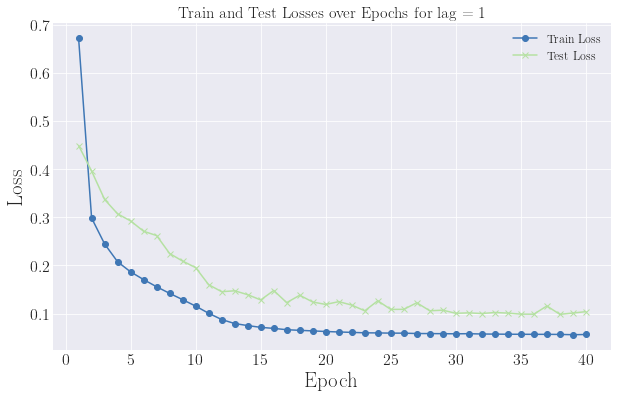

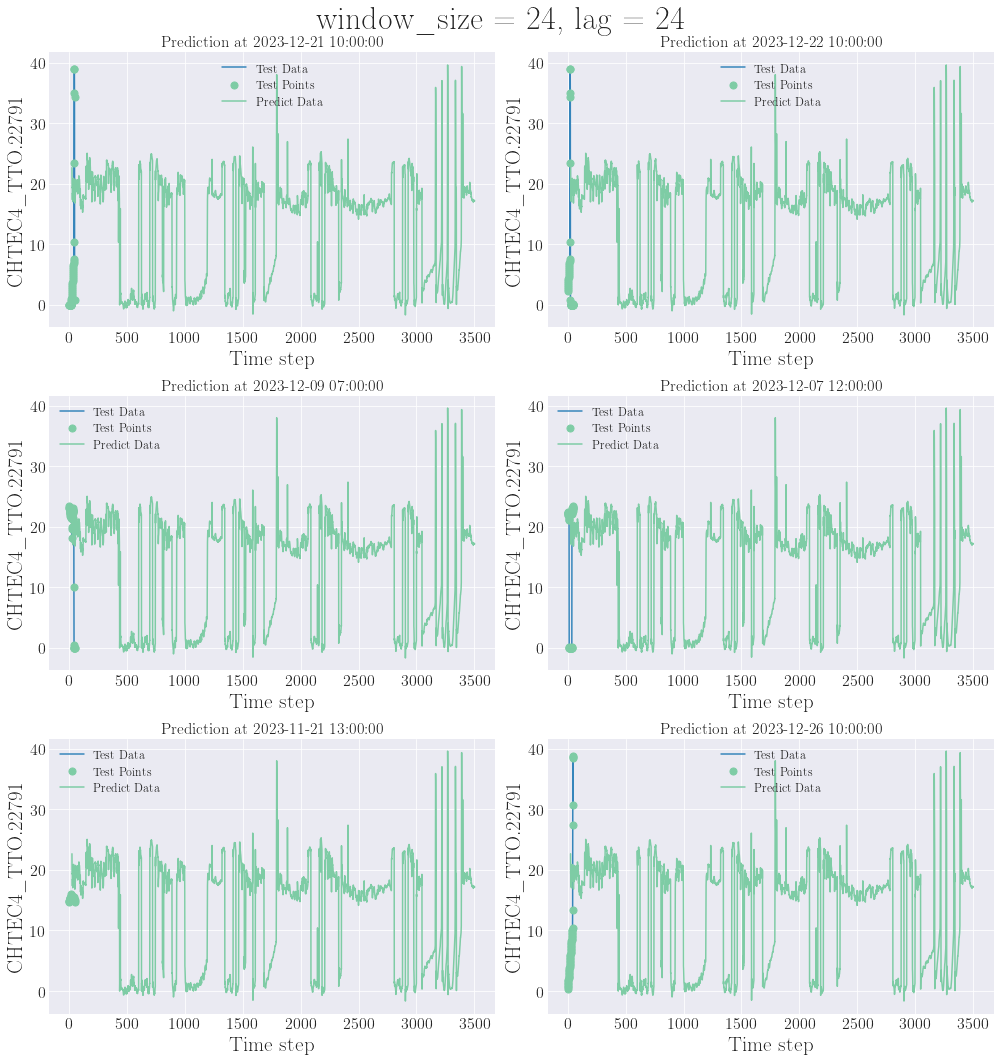

In [101]:
def run_pipeline(pipeline_func, lag, **kwargs):
    # start_time = time.time()
    best_test_loss, min_loss_ep, model_parameters, model = pipeline_func(lag=lag, **kwargs)
    # training_time = time.time() - start_time
    return best_test_loss, min_loss_ep, model_parameters, model
target_column = 'CHTEC4_TTO.22791'
lr = 0.00001
window_size = 24 * 1
best_test_loss, min_loss_ep, model_params, model = run_pipeline(
        pipline_LSTMModel,
        lag = 1,
        window_size=window_size,
        batch_size=64,
        hidden_dim=512,
        num_layers=3,
        num_epochs=40,
        learning_rate=0.00001,
        df_data_2_years=df_data_2_years,
        df=df,
        target_column = target_column,
        drop_columns=['time',  'CHTEC4_TTO.12452', 'CHTEC4_TTO.22790'], 
    )

In [ ]:
# # model = torch.load('lstm_model.pth')

# torch.save(model, 'lstm_model_aboba_final.pth')
# torch.save(model.state_dict(), 'lstm_model_state_dict_aboba_final.pth')

In [102]:
target_column

'CHTEC4_TTO.22791'

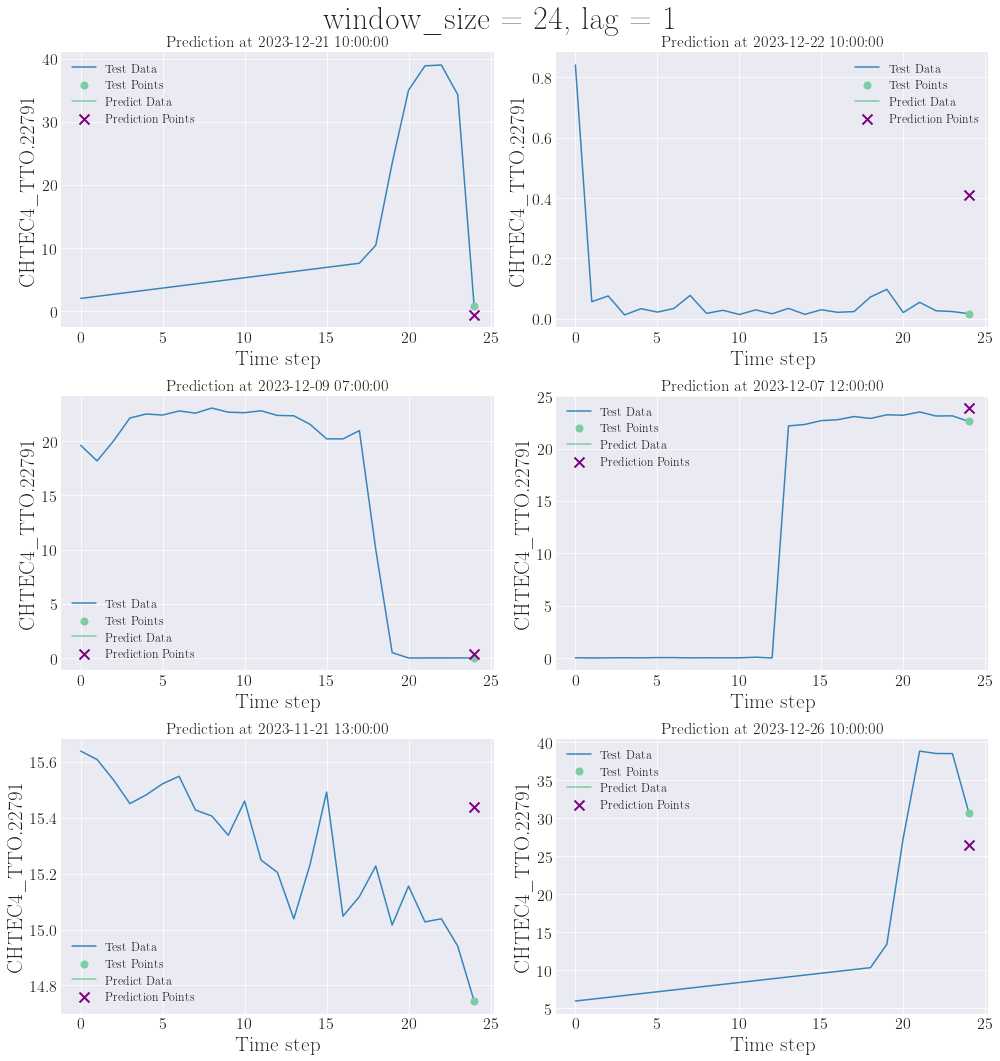

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drop_columns=['time',  'CHTEC4_TTO.12452', 'CHTEC4_TTO.22790']
try:
    df_merge = pd.merge(df_data_2_years, df, on='time')

    df_merged = df_merge.sort_values('time').reset_index(drop=True)

    train_end_idx = int(len(df_merged) * 0.8)
    df_train = df_merged.iloc[:train_end_idx - window_size].copy()
    df_test = df_merged.iloc[train_end_idx - window_size:].copy()

except: pass

# ----------------------------
# Нормализация данных
# ----------------------------
# Нормализуем все числовые столбцы, кроме time
try:
    features_cols = df_merged.columns.drop(['time', target_column])
except:
    features_cols = df_train.columns.drop(['time', target_column])

scaler = StandardScaler()

df_train[features_cols] = scaler.fit_transform(df_train[features_cols])
df_test[features_cols] = scaler.transform(df_test[features_cols])

target_scaler = StandardScaler()
df_train[target_column] = target_scaler.fit_transform(df_train[[target_column]])
df_test[target_column] = target_scaler.transform(df_test[[target_column]])

# Дата для прогноза
target_time_arr = [
    '2023-12-21 10:00:00',
    '2023-12-22 10:00:00',
    '2023-12-09 07:00:00',
    '2023-12-07 12:00:00',
    '2023-11-21 13:00:00',
    '2023-12-26 10:00:00',
]

df_test = df_test.reset_index(drop=True)
lag = 1
# print_ex(df_test, model, target_scaler, lag, window_size, device, target_time_arr, drop_columns)
print_ex(df_test, model, target_scaler, lag, window_size, device, target_time_arr, drop_columns)

In [92]:

target_column

'CHTEC4_TTO.22789'

[[22.65471901]
 [19.35203165]
 [19.38904246]
 ...
 [17.37511819]
 [17.22693275]
 [17.27502281]]
MAE: 1.020002478419337


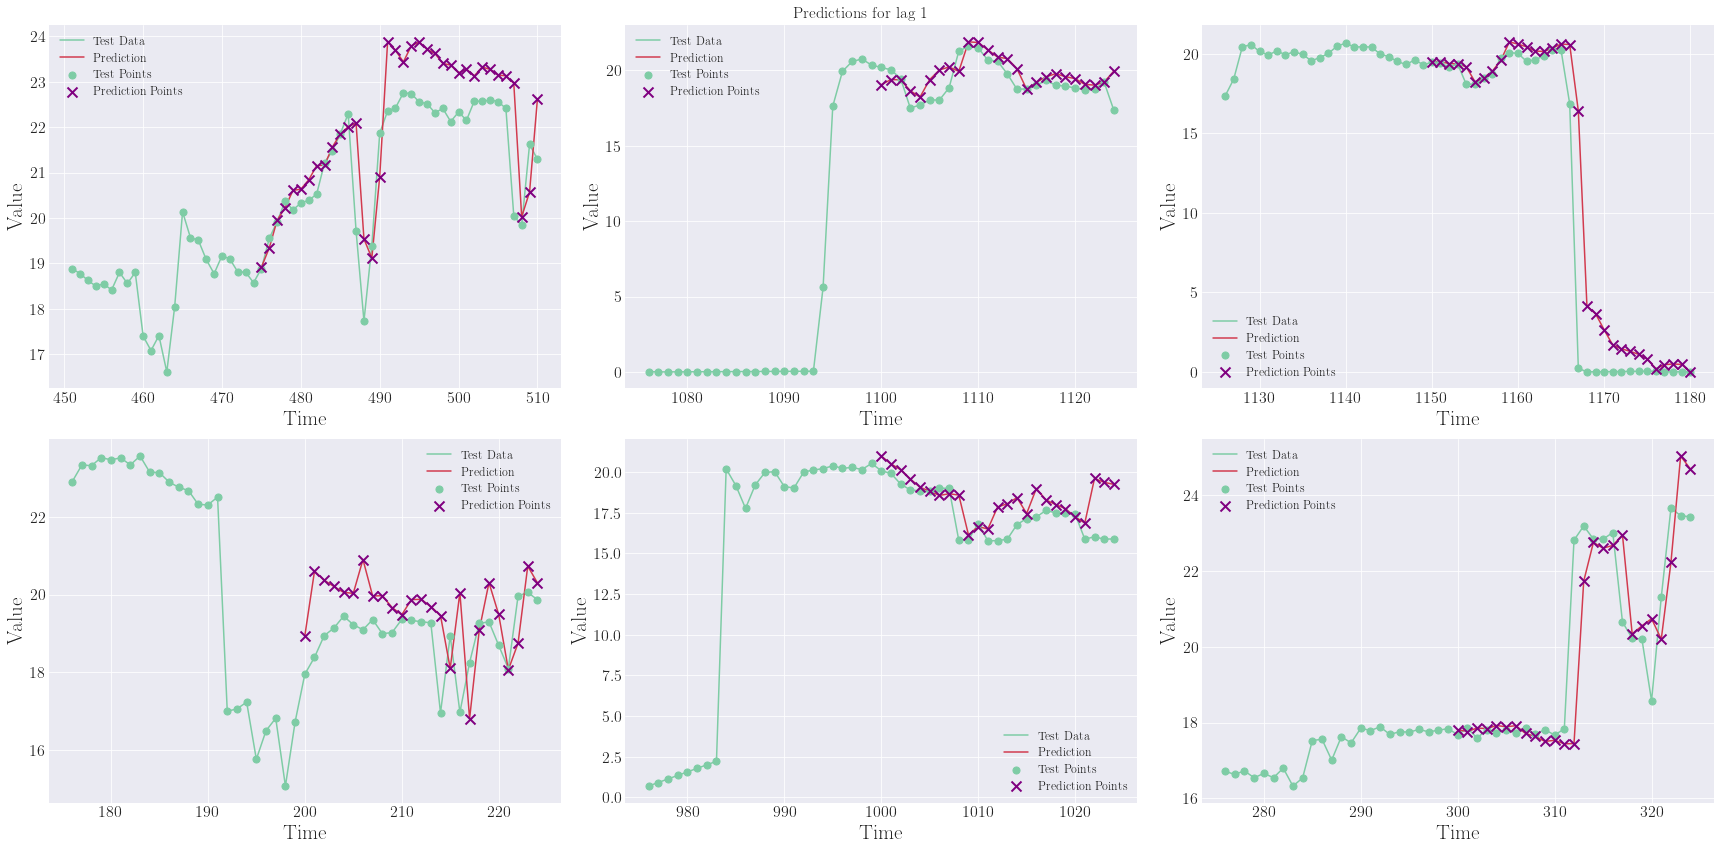

In [105]:

try:
    df_merge = pd.merge(df_data_2_years, df, on='time')

    df_merged = df_merge.sort_values('time').reset_index(drop=True)

    train_end_idx = int(len(df_merged) * 0.8)
    df_train = df_merged.iloc[:train_end_idx - window_size].copy()
    df_test = df_merged.iloc[train_end_idx - window_size:].copy()

except: pass

# ----------------------------
# Нормализация данных
# ----------------------------
# Нормализуем все числовые столбцы, кроме time
try:
    features_cols = df_merged.columns.drop(['time', target_column])
except:
    features_cols = df_train.columns.drop(['time', target_column])
    

scaler = StandardScaler()

# Параметры нормализации вычисляем только по обучающей выборке
df_train[features_cols] = scaler.fit_transform(df_train[features_cols])
df_test[features_cols] = scaler.transform(df_test[features_cols])

# print("Scaler mean:", scaler.mean_, "Scaler std:", scaler.scale_)

target_scaler = StandardScaler()
df_train[target_column] = target_scaler.fit_transform(df_train[[target_column]])
df_test[target_column] = target_scaler.transform(df_test[[target_column]])

# print(df_train)


train_dataset = TimeSeriesDataset(df_train, target_column=target_column, window_size=window_size, lag = lag, drop_columns = drop_columns)
test_dataset = TimeSeriesDataset(df_test, target_column=target_column, window_size=window_size, lag = lag, drop_columns = drop_columns)
batch_size= 64
# Создаем DataLoader'ы (без перемешивания, так как порядок важен)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lag = 1
test_dataset = TimeSeriesDataset(df_test, target_column=target_column, window_size=window_size, lag=lag, drop_columns=drop_columns)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch) 

outputs = outputs.cpu()

df_test = target_scaler.inverse_transform(df_test[target_column].values.reshape(-1, 1))
df_train = target_scaler.inverse_transform(df_train[target_column].values.reshape(-1, 1))
predictions_original_scale = target_scaler.inverse_transform(outputs.reshape(-1, 1))
predictions_original_scale = predictions_original_scale.reshape(-1, lag)
predictions_original_scale[predictions_original_scale < 0] = 0

train_data = df_train[-24*7:]
test_data = df_test[window_size:]
predictions = predictions_original_scale 


print(predictions)

errors = []


if lag > 1:
    # Calculate MAE for each lag
    for i in range(lag):
        mae = mean_absolute_error(test_data[i:len(outputs) + i], predictions[:, i])
        print(f"MAE for lag {i + 1}: {mae}")
        # Calculate errors for histogram
        errors.extend(test_data[i:len(outputs) + i] - predictions[:, i])
else:
    mae = mean_absolute_error(test_data, predictions)
    print(f"MAE: {mae}")
    # Calculate errors for histogram
    errors = test_data - predictions

train_time = range(len(train_data))
test_time = range(len(train_data), len(train_data) + len(df_test))
pred_time = range(len(train_data) + window_size, len(train_data) + len(predictions) + window_size )

intervals = [
        (475, 510),
        (1100, 1124),
        (1150, 1180),
        (200, 224),
        (1000, 1024),
        (300, 324)
    ]

# Создаем фигуру с несколькими subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
fig.suptitle(f'Predictions for lag 1', fontsize=16)
axes = axes.flatten()  # Преобразуем в 1D массив для удобства

for idx, (start, end) in enumerate(intervals):
    ax = axes[idx]
    
    # Создаем маски для выбора нужного диапазона
    test_mask = (np.array(test_time) >= start - window_size) & (np.array(test_time) <= end)
    pred_mask = (np.array(pred_time) >= start) & (np.array(pred_time) <= end)
    
    # Применяем маски к данным
    test_time_segment = np.array(test_time)[test_mask]
    y_test_segment = df_test[test_mask]
    
    pred_time_segment = np.array(pred_time)[pred_mask]
    y_pred_segment = predictions_original_scale[pred_mask]
    
    ax.plot(test_time_segment, y_test_segment, label='Test Data', color=colors[4])
    ax.plot(pred_time_segment, y_pred_segment, label=f'Prediction', color=colors[18])
    
    ax.scatter(test_time_segment, y_test_segment, color=colors[4], s=50, label='Test Points', zorder=5)
    ax.scatter(pred_time_segment, y_pred_segment, color='purple', marker='x', s=100, 
            linewidths=2, label='Prediction Points', zorder=5)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    # ax.set_title(f'Time {start}-{end}')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()


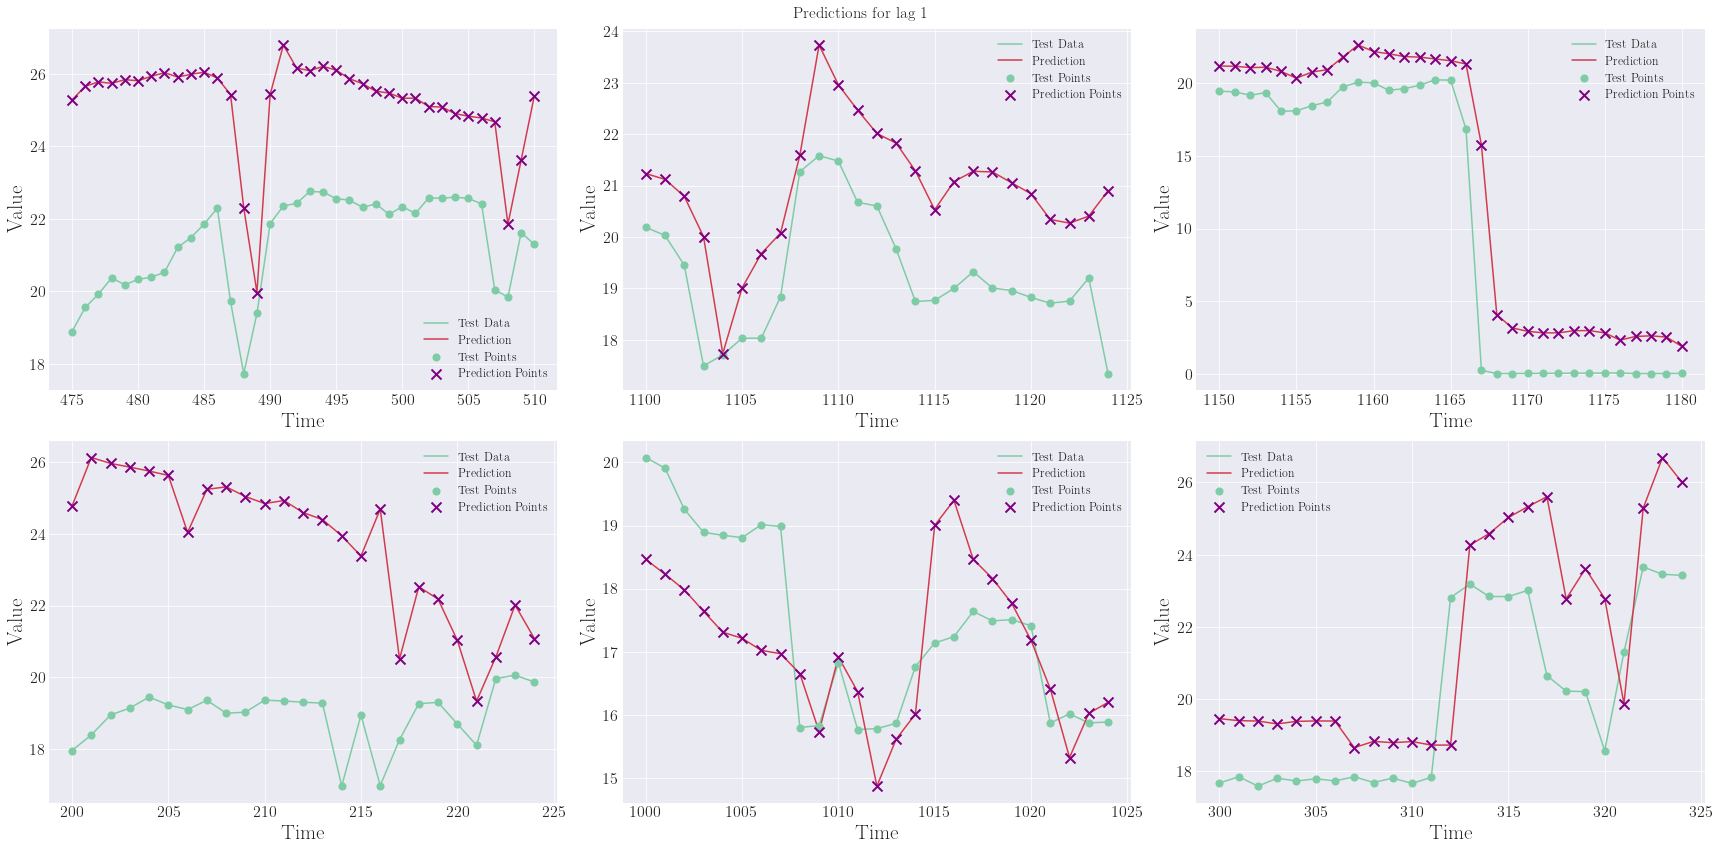